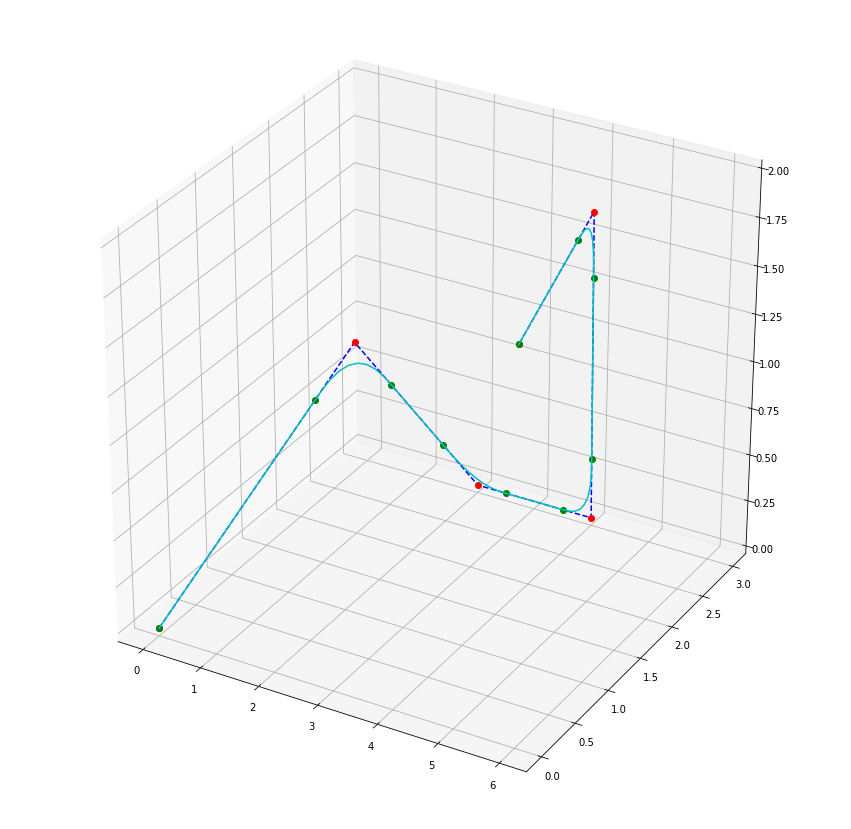

In [1]:
%matplotlib inline

from uuv_trajectory_generator import BezierCurve, LineSegment
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

q_x = [0, 1, 2, 4, 5, 6]
q_y = [0, 2, 3, 3, 2, 0]
q_z = [0, 1, 0, 0, 2, 2]

q = np.vstack((q_x, q_y, q_z)).T

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.plot(q[:, 0], q[:, 1], q[:, 2], 'b--')
ax.plot(q[:, 0], q[:, 1], q[:, 2], 'ro')

radius = 0.5

segments = list()
q_seg = np.array([q_x[0], q_y[0], q_z[0]])
q_start_line = deepcopy(q_seg)
for i in range(1, len(q_x)):
    line = LineSegment(q_start_line, q[i, :])
    if i < len(q_x) - 1:
        q_seg = np.vstack((q_seg, line.interpolate((line.get_length() - radius) / line.get_length())))
        segments.append(LineSegment(q_start_line, q_seg[-1, :]))
    if i == len(q_x) - 1:
        q_seg = np.vstack((q_seg, q[i, :]))
        segments.append(LineSegment(q_seg[-2, :], q_seg[-1, :]))
    elif i + 1 < len(q_x):
        line = LineSegment(q[i, :], q[i + 1, :])
        q_seg = np.vstack((q_seg, line.interpolate(radius / line.get_length())))
        segments.append(BezierCurve([q_seg[-2, :], q[i, :], q_seg[-1, :]], 5))
        q_start_line = deepcopy(q_seg[-1, :])

ax.plot(q_seg[:, 0], q_seg[:, 1], q_seg[:, 2], 'go')

lengths = [seg.get_length() for seg in segments]
lengths = [0] + lengths
total_length = np.sum(lengths)

u = np.cumsum(lengths) / total_length

pnts = None
deriv = None
for i in np.linspace(0, 1, 100):
    idx = (u - i >= 0).nonzero()[0][0]
    if idx == 0:
        u_k = 0
        pnts = segments[idx].interpolate(u_k)
        deriv = segments[idx].get_derivative(u_k)
    else:
        u_k = (i - u[idx - 1]) / (u[idx] - u[idx - 1])
        pnts = np.vstack((pnts, segments[idx - 1].interpolate(u_k)))
        deriv = np.vstack((deriv, segments[idx - 1].get_derivative(u_k)))

ax.plot(pnts[:, 0], pnts[:, 1], pnts[:, 2], 'c')

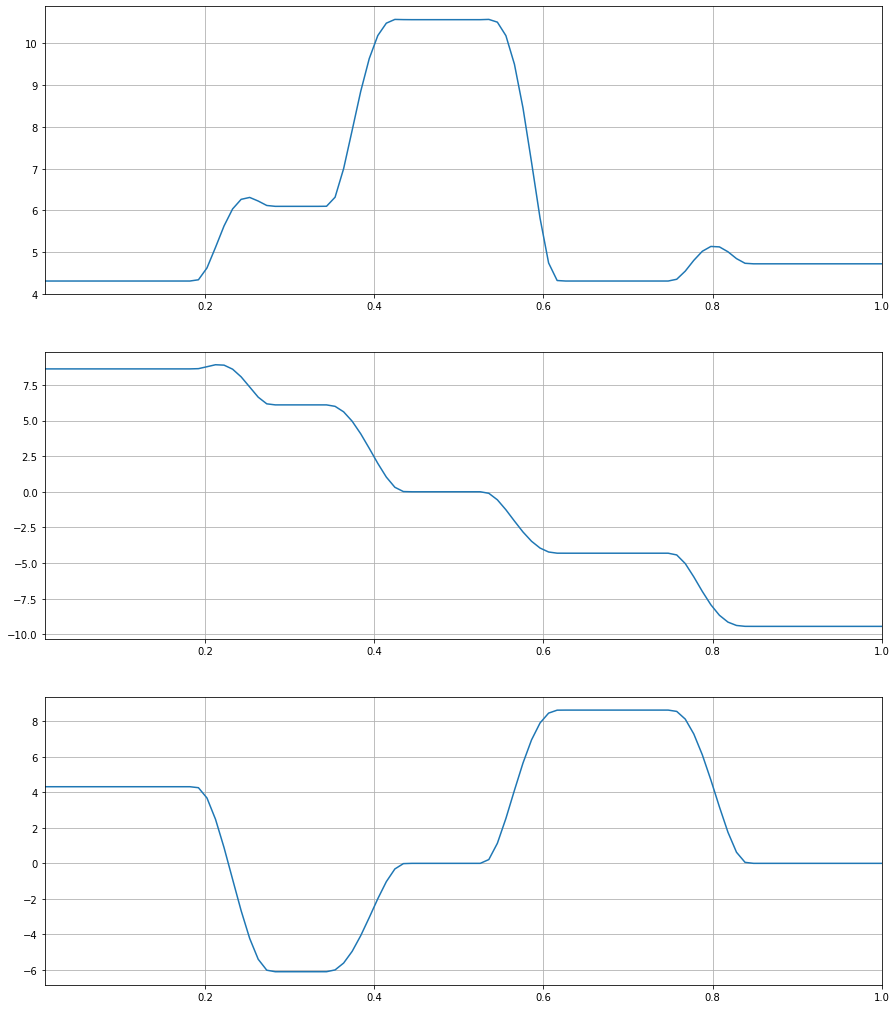

In [2]:
fig = plt.figure(figsize=(15, 18))

u_hat = np.linspace(0, 1, 100)
d_x = [(pnts[i, 0] - pnts[i - 1, 0]) / (u_hat[i] - u_hat[i - 1]) for i in range(1, pnts.shape[0])]
d_y = [(pnts[i, 1] - pnts[i - 1, 1]) / (u_hat[i] - u_hat[i - 1]) for i in range(1, pnts.shape[0])]
d_z = [(pnts[i, 2] - pnts[i - 1, 2]) / (u_hat[i] - u_hat[i - 1]) for i in range(1, pnts.shape[0])]

ax = fig.add_subplot(311)
ax.plot(u_hat[1::], d_x)
ax.set_xlim([u_hat[1::].min(), u_hat[1::].max()])
ax.grid(True)

ax = fig.add_subplot(312)
ax.plot(u_hat[1::], d_y)
ax.set_xlim([u_hat[1::].min(), u_hat[1::].max()])
ax.grid(True)

ax = fig.add_subplot(313)
ax.plot(u_hat[1::], d_z)
ax.set_xlim([u_hat[1::].min(), u_hat[1::].max()])
ax.grid(True)

plt.show()